<a href="https://colab.research.google.com/github/prachuryanath/Final-Year-Project/blob/main/FYP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Sep 16 20:17:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing the Dataset from Kaggle

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset
!unzip a-large-scale-fish-dataset

Streaming output truncated to the last 5000 lines.
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00435.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00436.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00437.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00438.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00439.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00440.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00441.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00442.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00443.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00444.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00445.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00446.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00447.png  
  inflating: Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/00448.png  
  inflating: Fish_Dataset/Fish_Dataset/

## Importing modules and Libraries

In [8]:
import numpy as np
import pandas as pd
import os

from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [9]:
dire = Path('/content/Fish_Dataset/Fish_Dataset')
filepaths = list(dire.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
1,/content/Fish_Dataset/Fish_Dataset/Striped Red...,Striped Red Mullet
2,/content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...,Sea Bass
3,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream
4,/content/Fish_Dataset/Fish_Dataset/Gilt-Head B...,Gilt-Head Bream


In [10]:
img_df['Labels'].value_counts()

Sea Bass              1000
Striped Red Mullet    1000
Gilt-Head Bream       1000
Red Mullet            1000
Trout                 1000
Shrimp                1000
Hourse Mackerel       1000
Red Sea Bream         1000
Black Sea Sprat       1000
Name: Labels, dtype: int64

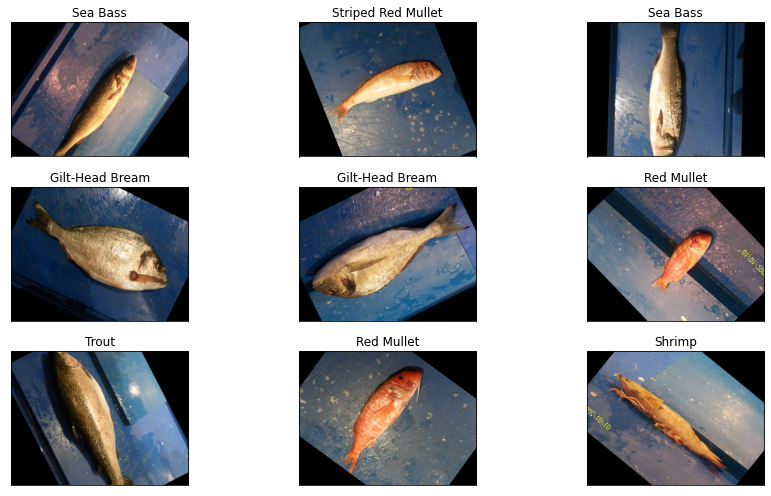

In [11]:
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

In [12]:
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (6299, 2)
Shape of Testing Data :  (1801, 2)
Shape of Validation Data :  (900, 2)


In [13]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6299 validated image filenames belonging to 9 classes.
Found 1801 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [14]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(113,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [19]:
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 3, callbacks=Callback)

Epoch 1/3
197/197 [==============================] - 66s 336ms/step - loss: 0.2754 - accuracy: 0.9089 - val_loss: 0.3137 - val_accuracy: 0.9022
Epoch 2/3
197/197 [==============================] - 67s 338ms/step - loss: 0.2259 - accuracy: 0.9243 - val_loss: 0.2789 - val_accuracy: 0.9178
Epoch 3/3
197/197 [==============================] - 66s 336ms/step - loss: 0.2104 - accuracy: 0.9321 - val_loss: 0.2771 - val_accuracy: 0.9189


In [20]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, None, None, None)  0         
                                                                 
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dropout_2 (Dropout)         (None, 128

In [21]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

57/57 [==============================] - 16s 288ms/step - loss: 0.2731 - accuracy: 0.9217
Test accuracy is :  92.17101335525513 %
